# Lesson 10: Model Toolbox

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2020_Spring/notebooks/10_Model_Toolbox.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Review some best practices
- Example of paramter recovery
- Discuss Modeler's Toolbox
- Example of a Recognition Memory Model


## Best Practices

- Show model fit
- Assess parameter recovery
- Demonstrate selective influence
- Quantify uncertainty in parameter estimates
- Engage in model selection

(See great introduction by Heathcote et al., 2015)

## Showing model fit - Anscombe's Quartet

![](https://upload.wikimedia.org/wikipedia/commons/e/ec/Anscombe%27s_quartet_3.svg)


## Selective Influence

- One option is demonstration of ecological validity 
  - (e.g., success in a real-world application)
- Barring that, we can perform experimental manipulations to isolate individual processes in the model
  - e.g., Speed-accuracy trade-off or Bias
  - Turning complex effects into simpler accounts in terms of latent variables
  

## Parameter Recovery

- Use a model to generate data with known parameters
- Perform model fits to recover those parameters
- Poor parameter recovery suggests difficulty in model interpretation


## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_spring/notebooks/CCR_quantcog.csv

In [ ]:
# to install more libraries
#!pip install plotnine
!pip install KDEpy
!pip install arviz

## Parameter Recovery Example

In [31]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import arviz as az

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
from RunDEMC.pda import PDA
from RunDEMC.io import arviz_dict

from joblib import Parallel, delayed


In [11]:
# define our LBA model
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.squeeze(np.atleast_1d(I))
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    inds[~resp_ind] = -1
    times[~resp_ind] = -1
    
    # make a dataframe
    return pd.DataFrame({'correct': inds, 'rt': times})
    


In [115]:
# generate some data with LBA
A = .25
b = 1.0
t0 = .2
I = (1.6, 2.4)
num_sims = 200
all_dat = lba_sim(I=I, A=A, b=b, t0=t0, num_sims=num_sims)
print('Num. Non-Resp:', (dat.correct == -1).sum())
all_dat.head()

Num. Non-Resp: 0


,correct,rt
0,1,0.849995
1,1,0.502158
2,1,0.445470
3,0,0.859580
4,1,0.422586


In [119]:
# only pick first n trials
n_trials = 100
dat = all_dat.iloc[:n_trials]

In [120]:
# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)


Text(0.5, 0, 'RT')

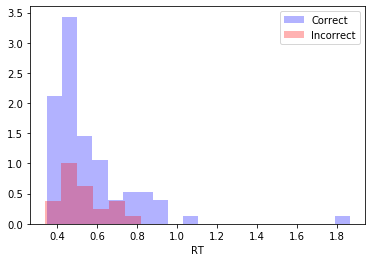

In [121]:
# plot our generated data
dhist(dat[(dat['correct']==1)]['rt'], len(dat), color='b');
dhist(dat[(dat['correct']==0)]['rt'], len(dat), color='r');
plt.legend(['Correct', 'Incorrect'])
plt.xlabel('RT')

In [122]:
# try and recover params
# set up the params
min_rt = dat.rt[dat.rt>0].min()
print('Min RT:', min_rt)
params = [Param(name='d1', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*10),
          Param(name='d2', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*10),
          Param(name='A', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*2),
          Param(name='b', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*5),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]

# set up PDA
rt_min = .05
rt_max = 2.1
pda = PDA(dat.loc[dat.rt > 0], cat_var='correct', cont_var='rt', transform=True, lower=rt_min, upper=rt_max)
print(pda._lower, pda._upper)

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b']): # or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        # calc log like via PDA
        likes[i] += pda.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
                
    return likes
        
# make the model
m = Model('decisions', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          pop_parallel=True,
          verbose=True)

Min RT: 0.3823177645432779
-70.05166769021623 0.4378970613691935


In [123]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(600, burnin=False)

Initializing: 50(50) 12(12) 2(2) 1(1) Iterations (100): 1 2 3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 26 27 28 29 = 30 31 32 33 34 = 35 36 37 38 39 = 40 41 42 43 44 = 45 46 47 48 49 = 50 51 52 53 54 = 55 56 57 58 59 = 60 61 62 63 64 = 65 66 67 68 69 = 70 71 72 73 74 = 75 76 77 78 79 = 80 81 82 83 84 = 85 86 87 88 89 = 90 91 92 93 94 = 95 96 97 98 99 = 100 
Iterations (600): 1 2 3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 26 27 28 29 = 30 31 32 33 34 = 35 36 37 38 39 = 40 41 42 43 44 = 45 46 47 48 49 = 50 51 52 53 54 = 55 56 57 58 59 = 60 61 62 63 64 = 65 66 67 68 69 = 70 71 72 73 74 = 75 76 77 78 79 = 80 81 82 83 84 = 85 86 87 88 89 = 90 91 92 93 94 = 95 96 97 98 99 = 100 101 102 103 104 = 105 106 107 108 109 = 110 111 112 113 114 = 115 116 117 118 119 = 120 121 122 123 124 = 125 126 127 128 129 = 130 131 132 133 134 = 135 136 137 138 139 = 140 141 142 143 144 = 145 146 147 148 149 = 150 151 152 153 154 = 155 156 157 158 159 = 1

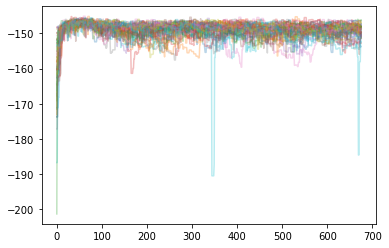

In [124]:
plt.plot(m.weights[25:], alpha=.3);

In [125]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -148.9384408283762
"d1": 1.545917,
"d2": 2.711960,
"A": 0.817323,
"b": 1.217294,
"t0": 0.275994,


In [126]:
# save out model to an ArviZ Inference Dataset
daz = az.from_dict(**arviz_dict(m, burnin=200))
daz.posterior

<xarray.Dataset>
Dimensions:  (chain: 50, draw: 501)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Data variables:
    d1       (chain, draw) float64 1.457 1.421 1.421 1.421 ... 3.139 2.022 2.022
    d2       (chain, draw) float64 2.529 2.751 2.751 2.751 ... 3.992 3.383 3.383
    A        (chain, draw) float64 0.669 1.052 1.052 ... 0.7268 0.4399 0.4399
    b        (chain, draw) float64 1.134 1.435 1.435 1.435 ... 2.72 1.876 1.876
    t0       (chain, draw) float64 0.2611 0.2773 0.2773 ... 0.09725 0.09725
Attributes:
    created_at:     2020-03-26T18:15:21.952380
    arviz_version:  0.7.0

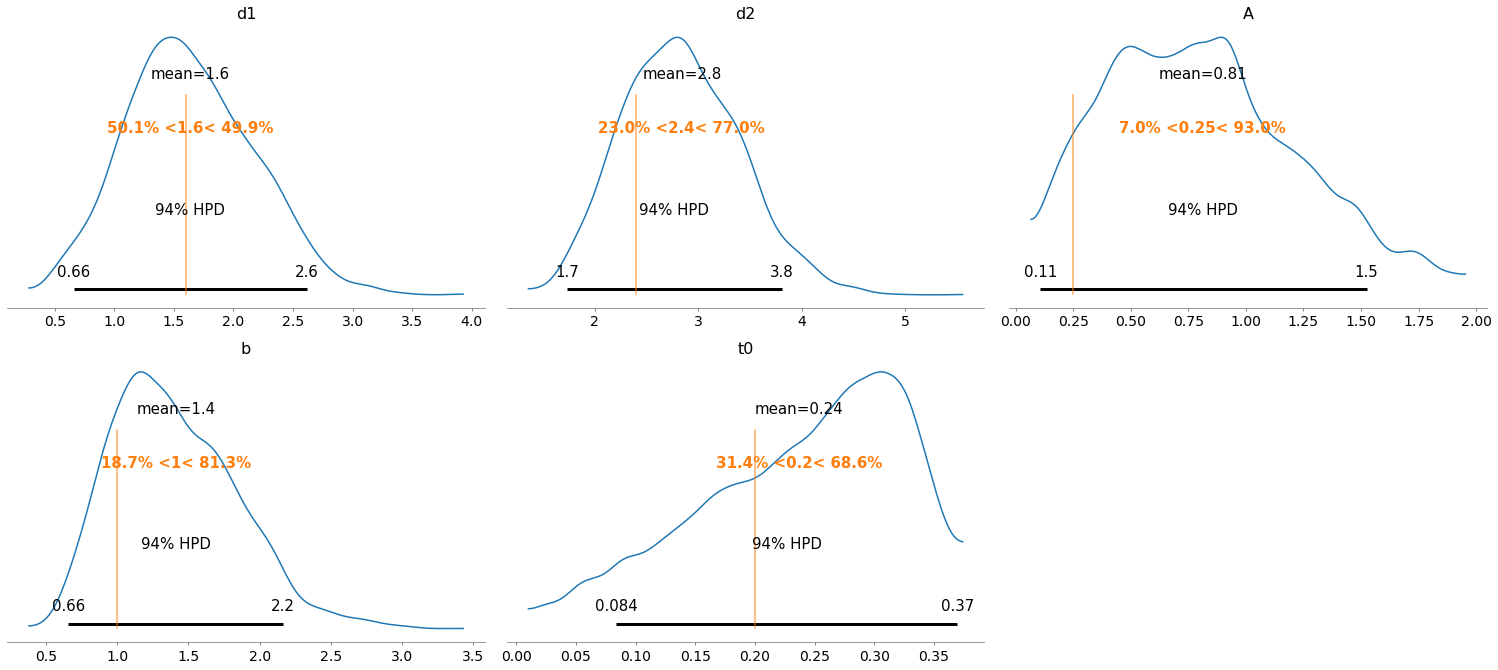

In [127]:
# see how the parameter recover worked out...
true_params = [I[0], I[1], A, b, t0]
az.plot_posterior(daz, ref_val=true_params);

## Model Toolkit

- What are the coding equivalents for common cognitive processes?

## Items/Stimuli

- A cognitive model must *represent* the stimuli in your experiment. 
- This can be as simple as a vector


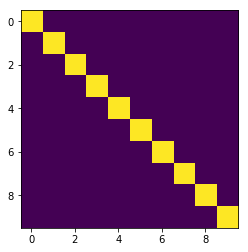

In [43]:
# orthogonal items in a list-learning experiment
nitems = 10
items = np.eye(nitems)

plt.imshow(items)

## Overlapping items

- Sometimes it's necessary for items to overlap (i.e., perceptually or semantically)
- Here you can simply add columns to your items

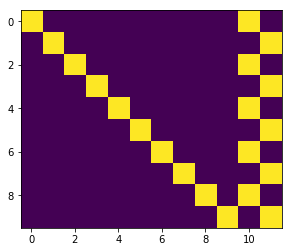

In [46]:
# overlapping items in a list-learning experiment
nitems = 10
ncolors = 2
nfeatures = nitems + ncolors
items = np.eye(nfeatures)
items = items[:nitems]

# add in color features
items[1::2, -1] = 1
items[::2, -2] = 1

plt.imshow(items)

## Working memory

- We can keep stimuli active, even when not just-presented
- Some options are:
  - buffers (e.g., SAM, Atkinson & Shiffrin)
  - exponential decay (e.g., TCM, Howard & Kahana)
  - time cells (e.g., SITH/TILT, Howard & Shankar)

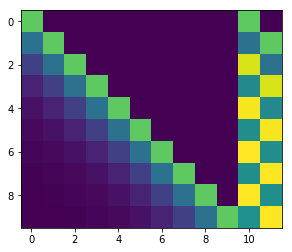

In [50]:
# present a list of items and store in working memory (context)
c = np.zeros(nfeatures)
c_save = []
rho = .5
for i in items:
    c = rho*c + (1-rho)*i
    c_save.append(c)
plt.imshow(c_save)
plt.xlabel('Feature')
plt.ylable('Timestep')

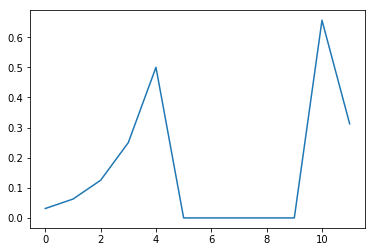

In [51]:
plt.plot(c_save[4])
plt.xlabel('Feature')
plt.ylabel('Activation')

## Associations

- In order to have a longer-term memory, we must form associations
- If items (and other information, such as working memory) is a vector, you can store and update associations in a matrix
- There are *many* potential associative memory rules:
  - Hebbian (simple outer product)
  - Prediction-error (e.g., Rescorla--Wagner)

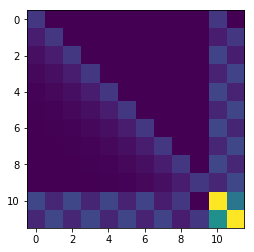

In [52]:
# form an outer product between an item and context
M = np.zeros((nfeatures, nfeatures))
for i in range(len(items)):
    M = M + np.outer(items[i], c_save[i])
plt.imshow(M)
plt.xlabel('Feature')
plt.ylabel('Feature')

## Querying Memory

- Once we have information stored in a matrix, you can pull it out with matrix multiplication

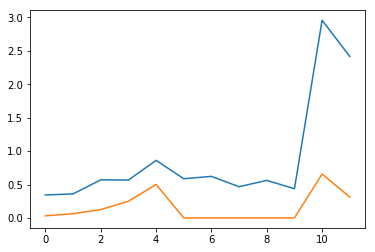

In [55]:
# retrieve an item from a context
s = np.dot(M, c_save[4])
plt.plot(s)
plt.plot(c_save[4])

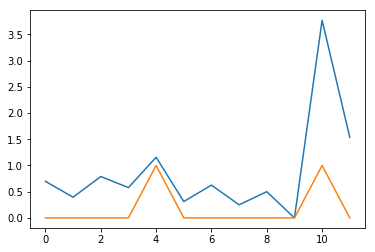

In [57]:
# probe from the other side to retrieve the context stored with an item
c_r = np.dot(items[4], M)
plt.plot(c_r)
plt.plot(items[4])

## Decisions

- If we have a strength value, we still need to generate a behavior
- Here we can employ many types of decision rules
- If we don't care about reaction-times, we can use a softmax rule ($\tau$ is a temperature parameter):

$$\frac{e^{\tau s_i}}{\sum_{j} e^{\tau s_j}}$$

$$\frac{s_i^\tau}{\sum_j s_j^\tau}$$

## Temporal Distinctiveness Example

In Siefke et al. (2019, *Memory & Cognition*) we wanted to test what it meant for an experience to be disctinctive:

https://link.springer.com/content/pdf/10.3758%2Fs13421-019-00925-5.pdf

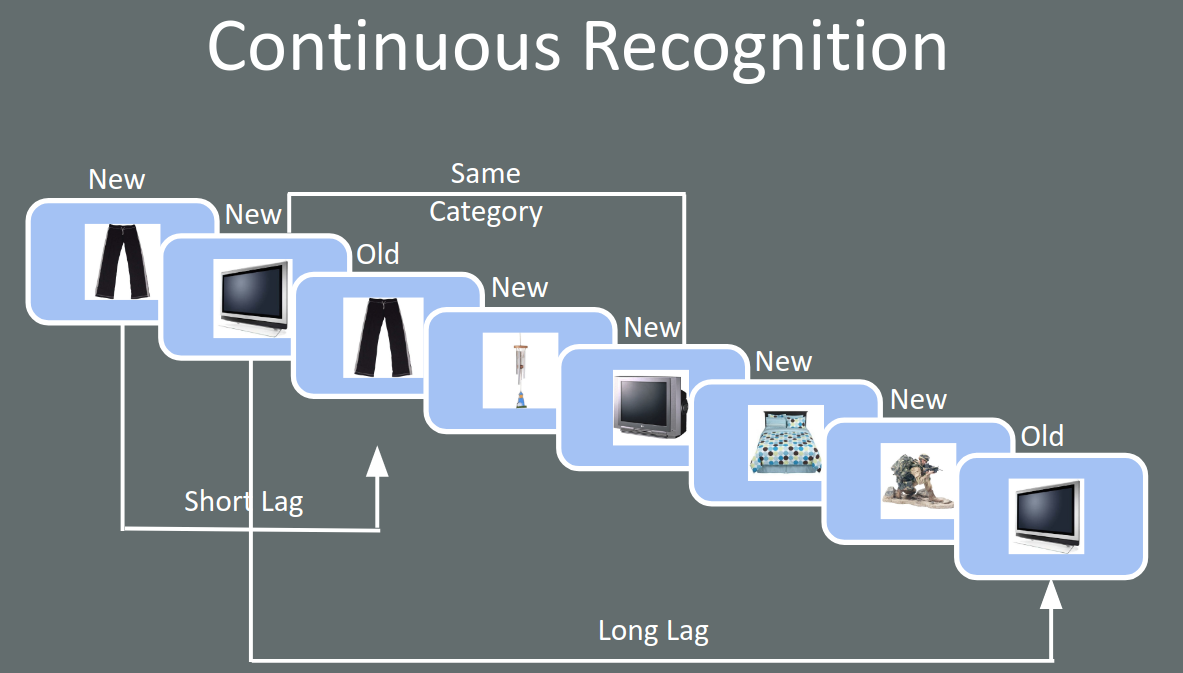

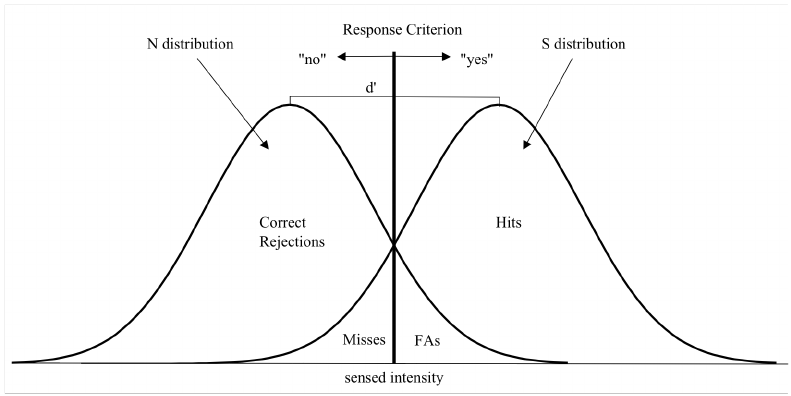


In [129]:
# import data
df_all = pd.read_csv('CCR_quantcog.csv')
subs = np.unique(df_all['subj'])
df_all.head()



,Unnamed: 0,appear_time_error,appear_time_time,base_time,block_num,cat,condition,correct,correct_resp,date,...,rt,run_num,stim,trial_num,subj,datetime,press_time,passed,cat_obj_nums,cat_trial_nums
0,0,0,178101.3885,NaN,0,lantern,new,NaN,H,6/9/2017,...,NaN,0,/sdcard/smile_images/17-objects/lantern/lanter...,0,1,20170609_111649,NaN,1,1,1
1,1,0,178104.0019,178104.1878,0,lantern,old,0.0,G,6/9/2017,...,0.645822,0,/sdcard/smile_images/17-objects/lantern/lanter...,1,1,20170609_111649,NaN,1,1,2
2,2,0,178106.4705,178106.6570,0,saltpeppershake,new,1.0,H,6/9/2017,...,0.932769,0,/sdcard/smile_images/17-objects/saltpeppershak...,2,1,20170609_111649,NaN,1,1,1
3,3,0,178109.1085,178109.2959,0,balloon,new,1.0,H,6/9/2017,...,0.870521,0,/sdcard/smile_images/17-objects/balloon/ABALLO...,3,1,20170609_111649,NaN,1,1,1
4,4,0,178111.5771,178111.7734,0,juice,new,1.0,H,6/9/2017,...,0.690777,0,/sdcard/smile_images/17-objects/juice/XB0EO.jpg,4,1,20170609_111649,NaN,1,1,1


In [130]:
# Analysis code from Kevin Darby
def make_metric(df, min_rt = .35, max_rt = 2., acc_col = 'correct', rt_col = 'rt'):
    
    mask = (df[rt_col] > min_rt) & (df[rt_col] < max_rt)
    corr_trials = df[mask][acc_col]
#     print(corr_trials)
    rt_trials = df[mask][rt_col]
    
    num_trials = df[mask].shape[0]
    if num_trials > 0:
        avec=((np.sum(corr_trials)/float(num_trials))-.5)/.5
        rvec=(np.sum([(np.log(max_rt+1.)-np.log(r+1.))/((np.log(max_rt+1.)-np.log(min_rt+1.)))
                    for r in rt_trials])/num_trials)
        score = avec*rvec
    else:
        avec = np.nan
        rvec = np.nan
        score = np.nan
    return avec, rvec, score

def get_Az(hr,far,n_h, n_f):

    hr_trans = ((hr*n_h)+.5)/(n_h+1)
    far_trans = ((far*n_f)+.5)/(n_f+1)
    Z = stats.norm.ppf
    d = Z(hr_trans) - Z(far_trans)
    Az = stats.norm.cdf(d/np.sqrt(2))

    return d, Az



In [131]:
# More code from Kevin Darby
categ_nums = [1,2]

dats = {'subject': [], 'categ_num': [], 'lag': [], 'd': [], 'hr': [], 'far': []}

for sub in subs:
    df_sub = df_all[df_all['subj'] == sub]
    
    for num in categ_nums:
        df_num = df_sub[df_sub['cat_obj_nums'] == num]
        lags = df_num['lag'].unique()
        lags.sort()
        for lag in lags:
            this_df = df_num[df_num['lag'] == lag]

            new = this_df[this_df['condition'] == 'new']
            old = this_df[this_df['condition'] == 'old']

            # Number of old and new trials
            n_h = old.shape[0]
            n_f = new.shape[0]

            if n_h > 0 and n_f > 0:

                # Hit and false alarm rates
                hr = old[old['correct'] == 1].shape[0] / n_h
                far = new[new['correct'] == 0].shape[0] / n_f

                # Calculate d' and A_z
                d, Az = get_Az(hr, far, n_h, n_f)

            else:
                d = np.nan
                Az = np.nan
                hr = np.nan
                far = np.nan

            dats['subject'].append(sub)
            dats['categ_num'].append(num)
            dats['lag'].append(lag)
            dats['d'].append(d)
            dats['hr'].append(hr)
            dats['far'].append(far)
            
dats_df = pd.DataFrame(dats)

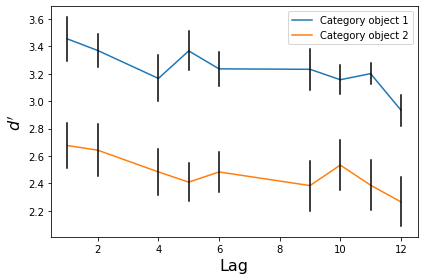

In [133]:
# plot d' as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel(r"$d'$", fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()

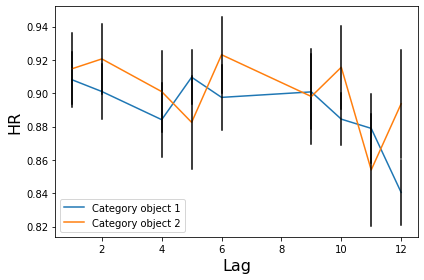

In [134]:
# plot HR as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel('HR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


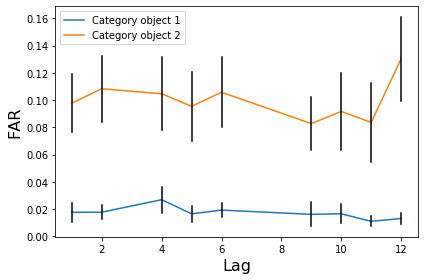

In [135]:
# plot FAR as a function of hit rate
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    
    ax = plt.gca()
    plt.plot(lags, means, label = 'Category object %s' %num);
    for i, sem in enumerate(sems):
        plt.plot([lags[i], lags[i]], [means[i] - sem, means[i] + sem], color = 'k')
    #chart_junk_be_gone(ax)

    plt.ylabel('FAR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


## Next Class: CCR Memory Model!!!